In [1]:
import cv2
import numpy as np 
import torch 
from torchvision import transforms, models 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision

ModuleNotFoundError: No module named 'cv2'

In [4]:
print(cv2.__version__)

4.8.0


In [6]:
import torchvision
import torch
dataset = torchvision.datasets.Caltech101('/Users/niteeqsheik/Desktop/CSE_515_Project',download=True)
data_loader = torch.utils.data.DataLoader(dataset,
batch_size=4,
shuffle=True,
num_workers=8)
print(len(dataset))

131740031it [00:04, 32584868.16it/s]


Extracting /Users/niteeqsheik/Desktop/CSE_515_Project/caltech101/101_ObjectCategories.tar.gz to /Users/niteeqsheik/Desktop/CSE_515_Project/caltech101


14028800it [00:00, 21527925.60it/s]


Extracting /Users/niteeqsheik/Desktop/CSE_515_Project/caltech101/Annotations.tar to /Users/niteeqsheik/Desktop/CSE_515_Project/caltech101
8677


In [7]:
print(len(dataset))

8677


# Color Moments Calculation 

In [8]:
from PIL import Image
from torchvision import datasets
import torch
import numpy as np
from scipy.stats import skew
import csv

# Initialize an empty list to store color moments
color_moments_list = []

# Initialize an empty list to store img_arrays (if needed)
all_img_arrays = []

# Loop through the dataset
for image_ID in range(len(dataset)):
    img, label = dataset[image_ID]
    
    # Step 1: Resize the image to 300x100
    new_size = (300, 100)
    img_resized = img.resize(new_size)
    
    # Convert the PIL Image to a NumPy array
    img_array = np.array(img_resized)
    
    #grayscale image check 
    is_gray = len(img_array.shape) == 2
    
    # Append the img_array to the list (if you need to keep all arrays)
    all_img_arrays.append(img_array)

    # Step 2: Partition the image into a 10x10 grid
    for i in range(0, 300, 30):
        for j in range(0, 100, 10):
            grid_cell = img_array[j:j+10, i:i+30]
            
            # Step 3: Calculate the color moments for each grid cell
            color_moments_dict = {}
            for color_channel, color_name in enumerate(['Gray'] if is_gray else ['Red', 'Green', 'Blue']):
                channel_data = grid_cell if is_gray else grid_cell[:, :, color_channel]

                # Calculate mean, standard deviation, and skewness
                channel_mean = np.mean(channel_data)
                channel_std = np.std(channel_data)
                if np.all(channel_data == channel_data[0]):
                    channel_skewness = 0
                else :
                    channel_skewness = skew(channel_data.reshape(-1))
                
                # Store the color moments in the dictionary
                color_moments_dict[f"{color_name}_Mean"] = channel_mean
                color_moments_dict[f"{color_name}_Std"] = channel_std
                color_moments_dict[f"{color_name}_Skewness"] = channel_skewness
            
            # Include the ImageID
            color_moments_dict["ImageID"] = image_ID
            
            # Append the color moments to the list
            color_moments_list.append(color_moments_dict)

# Check the length of the color_moments_list and all_img_arrays
print(f"The length of color_moments_list is {len(color_moments_list)}")
print(f"The length of all_img_arrays is {len(all_img_arrays)}")

# Write color_moments_list to CSV
csv_file_name = 'color_moments_with_imageID.csv'  # Change this to your preferred path

keys = ['ImageID'] + list(color_moments_list[0].keys())  # Include 'ImageID' as the first column header
with open(csv_file_name, 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, fieldnames=keys)
    dict_writer.writeheader()
    dict_writer.writerows(color_moments_list)

print(f"Color moments have been saved to {csv_file_name}")


The length of color_moments_list is 867700
The length of all_img_arrays is 8677


ValueError: dict contains fields not in fieldnames: 'Gray_Skewness', 'Gray_Mean', 'Gray_Std'

# HOG Calculation

In [9]:
# import cv2
# import numpy as np 
# import pandas as pd 
# import torch 
# import torchvision
# from tqdm import tqdm 

# #custom function for histogram 
# #this is done so that the the magnitudes are split proportionally in the bin
# def custom_histogram(angle,magnitude):
#     bins = np.linspace(0,360,10)
#     hist = np.zeros(9)
#     for ang, mag in zip(angle.flatten(), magnitude.flatten()):
#         bin_idx = int(ang // 40)
#         bin_overlap = ang / 40 - bin_idx
#         hist[bin_idx] += mag * (1 - bin_overlap)
#         if bin_overlap > 0:
#             hist[(bin_idx + 1) % 9] += mag* bin_overlap
#     return hist 

# #function to compute HOG_descriptor for a single image 
# def compute_hog(image):
#     #conditional check to check for already gray images
#     if len(image.shape) == 3 and image.shape[2] == 3:
#         gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else :
#         gray_img = image
#     resized_img = cv2.resize(gray_img, (300,100))
#     hog_descriptor = []  #this array is initialised to store the hog for one image 
#     counter = 0 
#     for y in range (0,100,10):
#         for x in range (0,300,30):
#             counter+=1
#             cell = resized_img[y:y+10,x:x+30]
#             dx = cv2.Sobel(cell, cv2.CV_64F, 1, 0, ksize=1)
#             dy = cv2.Sobel(cell, cv2.CV_64F, 0, 1, ksize=1)
#             mag, angle = cv2.cartToPolar(dx, dy)
#             hist = custom_histogram(angle, mag)
#             hog_descriptor.extend(hist)
#     hog_descriptor = np.array(hog_descriptor)
#     return hog_descriptor
# def save_to_csv(data,filename):
#     columns = ['ImageID'] + [f'HOG_{i}' for i in range(900)]
#     df = pd.DataFrame(data, columns=columns)
#     df.to_csv(filename, index=False)
    
# all_hog_descriptors = []   #to store the HOGs of all images 
# image_ids = []

# for image_id in tqdm(range(len(dataset)), total = len(dataset)):
#     img,label = dataset[image_id]
#     img = np.array(img)
#     hog_descriptor = compute_hog(img)
#     all_hog_descriptors.append(hog_descriptor)
#     image_ids.append(image_id)

# #numpy array conversion 
# all_hog_descriptors = np.array(all_hog_descriptors)
# image_ids = np.array(image_ids).reshape(-1,1)

# #adding the ImageID column 

# all_hog_descriptors_with_ids = np.hstack([image_ids, all_hog_descriptors])

# #saving to csv file 
# save_to_csv(all_hog_descriptors_with_ids,'hog_descriptors.csv')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [02:03<00:00, 70.07it/s]


In [156]:
print(type(dataset))

<class 'torchvision.datasets.caltech.Caltech101'>


In [158]:
from torchvision import datasets
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize
from PIL import Image
import numpy as np
from tqdm import tqdm

# Assuming you've already loaded the dataset like this:
# dataset = datasets.Caltech101('/path/to/dataset', download=True)

def extract_hog_features(image):
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    
    # Check if the image is grayscale
    if len(image_np.shape) == 2:
        gray_image = image_np
    else:
        gray_image = rgb2gray(image_np)
    
    # Resize the image
    resized_image = resize(gray_image, (300, 100))
    
    # Compute the HOG features
    features, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(10, 10),
                              cells_per_block=(1, 1), visualize=True)
    
    return features, hog_image

# Initialize empty dictionaries to store features and labels
hog_features_dict = {}
hog_images_dict = {}
labels_dict = {}

# Loop over the dataset with progress bar
for i in tqdm(range(len(dataset)), desc="Extracting HOG features"):
    image, label = dataset[i]
    features, hog_image = extract_hog_features(image)
    hog_features_dict[i] = features
    hog_images_dict[i] = hog_image
    labels_dict[i] = label

# Now:
# hog_features_dict contains the 900-dimensional feature descriptor for each image, indexed by dataset index
# hog_images_dict contains the visual representation of the HOG features for each image, indexed by dataset index
# labels_dict contains the label for each image, indexed by dataset index


Extracting HOG features: 100%|███████████████████████████████████████████████████████████████████████████████| 8677/8677 [03:46<00:00, 38.23it/s]


In [159]:
print(hog_features_dict[0])

[0.52334976 0.52334976 0.10359336 ... 0.21510143 0.25249509 0.35985098]


# Calculating Overall Mean and Std

In [11]:
#mean and standard deviation calculation from dataset directly 
from torchvision import datasets
import numpy as np
import torch
from tqdm import tqdm

sums_rgb = np.zeros(3)
squares_rgb = np.zeros(3)
pixel_count_rgb = 0

for i in tqdm(range(len(dataset))):
    image, label = dataset[i]
    image = np.array(image, dtype=np.float64)
    
    # Skip grayscale images
    if len(image.shape) != 3 or image.shape[2] != 3:
        continue
    # Sum up the pixel values and squares
    sums_rgb += np.sum(image, axis=(0, 1))
    squares_rgb += np.sum(np.square(image), axis=(0, 1))
    pixel_count_rgb += image.shape[0] * image.shape[1]

# Calculate mean and std for RGB
mean_rgb = sums_rgb / pixel_count_rgb
std_rgb = np.sqrt((squares_rgb / pixel_count_rgb) - np.square(mean_rgb))

print(f"Mean RGB: {mean_rgb}")
print(f"Standard Deviation RGB: {std_rgb}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:12<00:00, 689.56it/s]

Mean RGB: [137.68557595 132.62546541 125.59782581]
Standard Deviation RGB: [80.10850174 78.31718602 81.28992197]


In [12]:
#Calculating Mean and Standard Deviation After Image Scaling 
from torchvision import datasets
import numpy as np
import torch
from tqdm import tqdm

sums_rgb = np.zeros(3)
squares_rgb = np.zeros(3)
pixel_count_rgb = 0

for i in tqdm(range(len(dataset))):
    image, label = dataset[i]
    image = np.array(image, dtype=np.float64)
    image /=255.0
    # Skip grayscale images
    if len(image.shape) != 3 or image.shape[2] != 3:
        continue
    # Sum up the pixel values and squares
    sums_rgb += np.sum(image, axis=(0, 1))
    squares_rgb += np.sum(np.square(image), axis=(0, 1))
    pixel_count_rgb += image.shape[0] * image.shape[1]

# Calculate mean and std for RGB
mean_rgb = sums_rgb / pixel_count_rgb
std_rgb = np.sqrt((squares_rgb / pixel_count_rgb) - np.square(mean_rgb))

print(f"Mean RGB: {mean_rgb}")
print(f"Standard Deviation RGB: {std_rgb}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:12<00:00, 687.72it/s]

Mean RGB: [0.53994344 0.52009986 0.49254049]
Standard Deviation RGB: [0.31415099 0.30712622 0.31878401]


# Resnet 50 Layer's Ouput

In [15]:
resnet_model = models.resnet50(pretrained = True)

In [16]:
from torchvision import models, transforms
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.53994344, 0.52009986, 0.49254049], 
                         [0.31415099, 0.30712622, 0.31878401]),  # Normalize the images
])

def resnet_computations(hook_layer, dataset):
    
    # List to store the output tensors for each image along with their ImageID
    outputs_with_ids = []
    
    # List to temporarily capture the output tensor from the hook
    captured_output = [None]

    # Hook function to capture the output tensor of a specified layer
    def capture_output(module, input, output):
        captured_output[0] = output

    # Register the hook function to the specified layer
    if hook_layer == 'avgpool':
        hook = resnet_model.avgpool.register_forward_hook(capture_output)
    elif hook_layer == 'layer3':
        hook = resnet_model.layer3.register_forward_hook(capture_output)
    elif hook_layer == 'fc':   
        hook = resnet_model.fc.register_forward_hook(capture_output)

    # Loop through the dataset
    for i in tqdm(range(len(dataset))):
        img, label = dataset[i]
        #skipping grayscale images 
        if img.mode == 'L' or img.mode == '1':
            continue
        # Apply transformations and prepare image batch
        img_tensor = transform(img)
        img_batch = img_tensor.unsqueeze(0)  # Add a batch dimension

        # Forward pass (disable gradient computation to save memory)
        with torch.no_grad():
            resnet_model(img_batch)
        
        # Retrieve the captured output tensor
        resnet_output = captured_output[0]
        if resnet_output is None:
            print("Warning: Hook Not Triggered")
            continue

        # Process the output tensor depending on the specified layer and store it in a dictionary
        output_dict = {"ImageID": i}
        if hook_layer == 'avgpool':
            avgpool_output = resnet_output.flatten().cpu().numpy()
            averaged_values = [(avgpool_output[i] + avgpool_output[i+1]) / 2.0 for i in range(0, len(avgpool_output), 2)]
            output_dict["Output"] = np.array(averaged_values)
        elif hook_layer == 'layer3':
            avg_vector = resnet_output.mean(dim=[2, 3]).cpu().numpy().squeeze()
            output_dict["Output"] = avg_vector
        elif hook_layer == 'fc':
            output_dict["Output"] = resnet_output.cpu().numpy().squeeze()
        
        # Append the dictionary to the list
        outputs_with_ids.append(output_dict)
    
    # Remove the hook to free resources
    hook.remove()
    
    return outputs_with_ids

In [90]:
ouput_avgpool_with_ids = resnet_computations('avgpool',dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [06:50<00:00, 21.13it/s]


In [91]:
output_layers3_with_ids = resnet_computations('layer3',dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [07:10<00:00, 20.15it/s]


In [92]:
output_fc_with_ids = resnet_computations('fc',dataset)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [06:55<00:00, 20.91it/s]


In [94]:
print(ouput_avgpool_with_ids)

[{'ImageID': 0, 'Output': array([0.44561774, 0.44882405, 0.49240777, ..., 0.36020941, 0.41664082,
       0.37355679])}, {'ImageID': 1, 'Output': array([0.48392487, 0.44350559, 0.52613771, ..., 0.35611588, 0.37269533,
       0.40935212])}, {'ImageID': 2, 'Output': array([0.48366529, 0.45623219, 0.52387196, ..., 0.34862804, 0.38696036,
       0.39072061])}, {'ImageID': 3, 'Output': array([0.49069762, 0.51305747, 0.54397798, ..., 0.31994557, 0.40682161,
       0.38987345])}, {'ImageID': 4, 'Output': array([0.45035383, 0.47819394, 0.5153873 , ..., 0.35593095, 0.38770321,
       0.41411027])}, {'ImageID': 5, 'Output': array([0.47599542, 0.42141336, 0.4949035 , ..., 0.33744958, 0.3661173 ,
       0.38089597])}, {'ImageID': 6, 'Output': array([0.48485792, 0.45193082, 0.51504338, ..., 0.35780594, 0.37992638,
       0.38144952])}, {'ImageID': 7, 'Output': array([0.48952347, 0.47186533, 0.53051198, ..., 0.36052239, 0.38398752,
       0.39195758])}, {'ImageID': 8, 'Output': array([0.49116215, 0.4

# User Interface 

In [20]:
def resnet_computations_single_image(hook_layer, img):
 
    
    # Variable to temporarily capture the output tensor from the hook
    captured_output = [None]

    # Hook function to capture the output tensor of a specified layer
    def capture_output(module, input, output):
        # Capture the output tensor
        captured_output[0] = output

    # Register the hook function to the specified layer
    if hook_layer == 'avgpool':
        hook = resnet_model.avgpool.register_forward_hook(capture_output)
    elif hook_layer == 'layer3':
        hook = resnet_model.layer3.register_forward_hook(capture_output)
    elif hook_layer == 'fc':   
        hook = resnet_model.fc.register_forward_hook(capture_output)

    # Skip grayscale images
    if img.mode == 'L' or img.mode == '1':
        print("Warning: Skipping grayscale image.")
        return None

    # Apply transformations and prepare image batch
    img_tensor = transform(img)
    img_batch = img_tensor.unsqueeze(0)  # Add a batch dimension

    # Forward pass (disable gradient computation to save memory)
    with torch.no_grad():
        resnet_model(img_batch)

    # Retrieve the captured output tensor
    resnet_output = captured_output[0]
    if resnet_output is None:
        print("Warning: The hook has not been triggered.")
        return None

    # Process the output tensor depending on the specified layer
    if hook_layer == 'avgpool':
        # Flatten the output tensor to a 1D array
        avgpool_output = resnet_output.flatten()
        # Reduce the dimensions from 2048 to 1024 by averaging each pair of adjacent numbers
        averaged_values = [(avgpool_output[i] + avgpool_output[i+1]) / 2.0 for i in range(0, len(avgpool_output), 2)]
        averaged_values = np.array(averaged_values)  # Convert to NumPy array
        return averaged_values
    elif hook_layer == 'layer3':
        # Compute the mean along dimensions 2 and 3 to get a 1024-dimensional vector
        avg_vector = resnet_output.mean([2, 3])
        # Remove singleton dimensions (if any)
        avg_vector = avg_vector.squeeze()
        # Convert the tensor to a NumPy array
        return avg_vector.numpy()
    elif hook_layer == 'fc':
        # For the fully connected layer, the output is already a 1000-dimensional tensor.
        # Convert the tensor to a NumPy array
        return resnet_output.numpy()

    # Remove the hook to free resources
    hook.remove()


In [21]:
from skimage.io import imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

def process_and_visualize_image(img):
    print(f"Original image shape: {img.shape}")

    # Resizing the image
    resized_img = resize(img, (300, 100))
    print(f"Resized image shape: {resized_img.shape}")

    # Show the resized image
    print("Resized Image:")
    imshow(resized_img)
    plt.show()

    # Computing HOG features
    fd, hog_img = hog(resized_img, orientations=9, pixels_per_cell=(10, 10),
                      cells_per_block=(2, 2), visualize=True, channel_axis=-1)

    print(f"Length of HOG Descriptor: {fd.shape}")

    # Show the HOG visualization
    print("HOG Visualization:")
    plt.axis("off")
    plt.imshow(hog_img, cmap="gray")
    plt.show()

In [22]:
print(len(color_moments_list))

867700


In [37]:
def get_color_moments_for_image_ID(image_ID):
    return [entry for entry in color_moments_list if entry['ImageID']== image_ID]


Enter the image ID to process (or 'q' to quit): 0
HOG Visualisation 

Original image shape: (337, 510, 3)
Resized image shape: (300, 100, 3)
Resized Image:


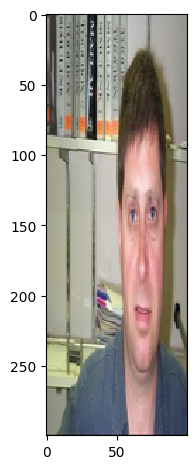

Length of HOG Descriptor: (9396,)
HOG Visualization:


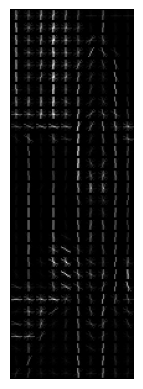

0
Color Moments of Image

[{'Red_Mean': 100.8, 'Red_Std': 41.41875581585393, 'Red_Skewness': 0.16085438086671136, 'Green_Mean': 99.24333333333334, 'Green_Std': 45.00774883901166, 'Green_Skewness': 0.17247527297226498, 'Blue_Mean': 94.04333333333334, 'Blue_Std': 46.81197982947907, 'Blue_Skewness': 0.11610896598270831, 'ImageID': 0}, {'Red_Mean': 106.68333333333334, 'Red_Std': 37.37436361405443, 'Red_Skewness': 0.07447969645366764, 'Green_Mean': 105.92333333333333, 'Green_Std': 40.56834713035384, 'Green_Skewness': 0.07989657621945997, 'Blue_Mean': 103.02666666666667, 'Blue_Std': 41.065305172236194, 'Blue_Skewness': -0.049049819061903206, 'ImageID': 0}, {'Red_Mean': 107.11, 'Red_Std': 42.294419253608396, 'Red_Skewness': 0.22089265525312407, 'Green_Mean': 100.82, 'Green_Std': 45.11187131269699, 'Green_Skewness': 0.4195087448989421, 'Blue_Mean': 91.51, 'Blue_Std': 44.335650440700654, 'Blue_Skewness': 0.3606026611401208, 'ImageID': 0}, {'Red_Mean': 161.11, 'Red_Std': 14.341707243793072, 'Red

KeyboardInterrupt: Interrupted by user

In [161]:
import torchvision 
import torch
import torch.nn as nn 
import torchvision.models as models 
import numpy as np 

while True:
    image_id_str = input("Enter the image ID to process (or 'q' to quit): ")
    if image_id_str.lower() == 'q':
        break
    
    try:
        image_id = int(image_id_str)
    except ValueError:
        print("Invalid input. Please enter an integer.")
        continue
    
    if image_id < 0 or image_id >= len(dataset):
        print(f"Invalid image ID. Please enter a number between 0 and {len(dataset) - 1}.")
        continue
    
    # Fetch the image from the dataset
    img, label = dataset[image_id]
    img_in_array = np.array(img)
    print("HOG Visualisation \n")
    #Processing and visualizing image 
    process_and_visualize_image(img_in_array)
    #compute color moments
    color_moments_list_input_img = get_color_moments_for_image_ID(image_id)
    
    #compute HOG
    HOG_descriptor_input_img = extract_hog_features(img)
    
    # Compute the output using the resnet_computations_single_image function
    output_input_img_avgpool = resnet_computations_single_image('avgpool', img)
    output_input_img_layer3 = resnet_computations_single_image('layer3', img)
    output_input_img_fc = resnet_computations_single_image('fc', img)
    print(image_id)
    print("Color Moments of Image\n")
    print(color_moments_list_input_img)
    print("HOG descriptor of given image\n")
    print(HOG_descriptor_input_img)
    if output_input_img_avgpool is not None:
        print(f"Output AvgPool for image ID {image_id}:\n{output_input_img_avgpool} \n")

    if output_input_img_layer3 is not None:
        print(f"Output Layer3 for image ID {image_id}:\n{output_input_img_layer3} \n")

    if output_input_img_fc is not None:
        print(f"Output FC for image ID {image_id}:\n{output_input_img_fc}\n")
    
# Exit message
print("Exiting the program.")

In [36]:
print(color_moments_list[0])
print(color_moments_list[99])
print(color_moments_list[100])

{'Red_Mean': 100.8, 'Red_Std': 41.41875581585393, 'Red_Skewness': 0.16085438086671136, 'Green_Mean': 99.24333333333334, 'Green_Std': 45.00774883901166, 'Green_Skewness': 0.17247527297226498, 'Blue_Mean': 94.04333333333334, 'Blue_Std': 46.81197982947907, 'Blue_Skewness': 0.11610896598270831, 'ImageID': 0}
{'Red_Mean': 53.096666666666664, 'Red_Std': 5.432677874574278, 'Red_Skewness': -0.9665916102914293, 'Green_Mean': 66.79333333333334, 'Green_Std': 5.480020275712693, 'Green_Skewness': -0.8279769291526132, 'Blue_Mean': 88.55, 'Blue_Std': 6.776491225799185, 'Blue_Skewness': -0.8881800352185352, 'ImageID': 0}
{'Red_Mean': 16.97, 'Red_Std': 14.984517565362811, 'Red_Skewness': 0.8616395979431994, 'Green_Mean': 59.28, 'Green_Std': 28.979905681926112, 'Green_Skewness': -0.4647073143627668, 'Blue_Mean': 101.34333333333333, 'Blue_Std': 37.216198832706645, 'Blue_Skewness': -0.8247633018593968, 'ImageID': 1}


# Closest Image Retrieval 

In [177]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

def find_closest_images(input_image_color_moments):
    closest_images = []
    num_images = len(color_moments_list) // 100  # Assuming each image contributes 100 dictionaries

    # Determine if the input image is grayscale based on the number of keys in the first dictionary
    is_input_gray = len(input_image_color_moments[0].keys()) - 1 == 3  # Minus 1 for 'ImageID'

    # Loop through each set of 100 dictionaries for each image
    for i in tqdm(range(num_images)):
        
        # Determine if the stored image is grayscale based on the number of keys in the first dictionary for this image
        is_stored_gray = len(color_moments_list[i * 100].keys()) - 1 == 3  # Minus 1 for 'ImageID'
        
        # Skip the comparison if one is grayscale and the other is not
        if is_input_gray != is_stored_gray:
            continue

        total_distance = 0
        for j in range(100):
            input_grid_moments = input_image_color_moments[j]
            stored_grid_moments = color_moments_list[i * 100 + j]

            # Extract only the color moment values, ignore 'ImageID'
            input_values = [val for key, val in input_grid_moments.items() if key != 'ImageID']
            stored_values = [val for key, val in stored_grid_moments.items() if key != 'ImageID']

            # Compute the Euclidean distance
            grid_distance = np.linalg.norm(np.array(input_values) - np.array(stored_values))
            total_distance += grid_distance

        image_id = color_moments_list[i * 100]['ImageID']  # Assuming all grids for an image have the same ImageID
        closest_images.append((image_id, total_distance))

    # Sort by total_distance
    closest_images.sort(key=lambda x: x[1])

    return closest_images[1:11]  # Return the 10 closest images


In [46]:
input_image_color_moments = get_color_moments_for_image_ID(0)

In [67]:
closest_images = find_closest_images(input_image_color_moments)
print(closest_images)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:04<00:00, 2049.16it/s]

[(0, 0.0), (155, 6522.537489568226), (5160, 6659.965562259577), (3196, 6696.757134834082), (435, 6780.418940786412), (8188, 6928.663152688041), (5058, 6971.486155242581), (4978, 6988.849696564484), (4255, 7060.165349978116), (6181, 7083.271436974557)]


In [178]:
from scipy.spatial import distance
from heapq import heapify, heappush, nsmallest

def find_top_10_similar(new_img_features, stored_outputs_with_ids):
    heap = []
    heapify(heap)
    
    for stored_output in stored_outputs_with_ids:
#         print(stored_output["Output"].shape, "Stored")
#         print(new_img_features.shape, "new img")
        sim = distance.euclidean(new_img_features, stored_output["Output"])
        heappush(heap, (sim, stored_output["ImageID"]))
    
    return nsmallest(11, heap)

# Calculate feature vectors for the new image for each layer
new_img_features_avgpool = resnet_computations_single_image('avgpool', new_img)
new_img_features_layer3 = resnet_computations_single_image('layer3', new_img)
new_img_features_fc = resnet_computations_single_image('fc', new_img).reshape(1000)

# Find the top 10 most similar images for each layer
# print("avgpool")
top_10_similar_avgpool = find_top_10_similar(new_img_features_avgpool, ouput_avgpool_with_ids)
# print("layer3")
top_10_similar_layer3 = find_top_10_similar(new_img_features_layer3, output_layers3_with_ids)
# print("fc")
top_10_similar_fc = find_top_10_similar(new_img_features_fc, output_fc_with_ids)

# Print the results
print("Top 10 similar images based on 'avgpool' layer:")
for sim, img_id in top_10_similar_avgpool:
    print(f"Image ID: {img_id}, Similarity: {sim}")

print("\nTop 10 similar images based on 'layer3' layer:")
for sim, img_id in top_10_similar_layer3:
    print(f"Image ID: {img_id}, Similarity: {sim}")

print("\nTop 10 similar images based on 'fc' layer:")
for sim, img_id in top_10_similar_fc:
    print(f"Image ID: {img_id}, Similarity: {sim}")


Top 10 similar images based on 'avgpool' layer:
Image ID: 4195, Similarity: 0.0
Image ID: 5543, Similarity: 0.8993314143815097
Image ID: 7430, Similarity: 0.9101831709651129
Image ID: 7651, Similarity: 0.918937701435989
Image ID: 7350, Similarity: 0.9216331749850704
Image ID: 7443, Similarity: 0.9222430862043487
Image ID: 5638, Similarity: 0.922567168930066
Image ID: 2870, Similarity: 0.925242946905158
Image ID: 6388, Similarity: 0.9256530826246187
Image ID: 5976, Similarity: 0.9261505126008048
Image ID: 965, Similarity: 0.9282459510987551

Top 10 similar images based on 'layer3' layer:
Image ID: 4195, Similarity: 0.0
Image ID: 7339, Similarity: 0.21690914034843445
Image ID: 6818, Similarity: 0.2177986055612564
Image ID: 5157, Similarity: 0.2187623530626297
Image ID: 7682, Similarity: 0.21924792230129242
Image ID: 4144, Similarity: 0.2222212553024292
Image ID: 7161, Similarity: 0.22280101478099823
Image ID: 7687, Similarity: 0.22301295399665833
Image ID: 4231, Similarity: 0.22311070561

In [179]:
from scipy.spatial import distance

# Assuming hog_features_dict and dataset are defined globally

def find_similar_images(input_image):
    
    # Step 1: Compute the HOG features for the input image
    input_features, _ = extract_hog_features(input_image)
    
    # Step 2: Compute Euclidean distances (similarity scores)
    distances = {}
    for i, features in hog_features_dict.items():
        dist = distance.euclidean(input_features, features)
        distances[i] = dist
    
    # Step 3: Sort the distances and find the 10 most similar images
    sorted_indices = sorted(distances, key=distances.get)[1:11]
    
    # Step 4: Retrieve the corresponding IDs and similarity scores
    results = [(i, distances[i]) for i in sorted_indices]
    
    return results

# To use this function, you would do something like this:
# input_image = some PIL Image object
# similar_image_ids, similarity_scores = find_similar_images(input_image)

# Now, 'similar_image_ids' contains the IDs (indices in the dataset) of the 10 most similar images
# 'similarity_scores' contains the similarity scores (Euclidean distances) for these images


In [170]:
img , label = dataset[0]
result_HOG = find_similar_images(img)
print(result_HOG)

[(0, 0.0), (6193, 9.683682003864012), (5836, 9.715253745702775), (8226, 9.838619552627847), (8370, 9.876819414817554), (8187, 9.88074801086846), (4311, 9.88949200442366), (7389, 9.899538737230237), (7118, 9.910657233173929), (8319, 9.916187209225273), (5680, 9.927742421780504)]


In [202]:
import json
def user_interface():
    # User inputs an image ID
    results = {}
    image_id_str = input("Enter the image ID to process (or 'q' to quit): ")
    if image_id_str.lower() == 'q':
        print("Exiting the program.")
        return
    
    try:
        image_id = int(image_id_str)
    except ValueError:
        print("Invalid input. Please enter an integer.")
        return
    
    # Fetch the image and compute its features
    print("Input Image")
    image_visualizer(image_id, save_path = f"/Users/niteeqsheik/Desktop/input_image_{image_id}.png")
    img, label = dataset[image_id]
    new_img_color_moments = get_color_moments_for_image_ID(image_id)
    new_img_features = {
        'avgpool': resnet_computations_single_image('avgpool', img),
        'layer3': resnet_computations_single_image('layer3', img),
        'fc': resnet_computations_single_image('fc', img).reshape(1000)
    }

    # Find and display the closest images based on color moments
    closest_images_color_moments = find_closest_images(new_img_color_moments)
    display_results(closest_images_color_moments, "Color Moments")
    results['Color Moments'] = closest_images_color_moments
    
    #using HOG 
    closest_images_HOG = find_similar_images(img)
    display_results(closest_images_HOG,'HOG')
    results['HOG'] = closest_images_HOG

    # Find and display the closest images based on ResNet features
    closest_images_avgpool = find_top_10_similar(new_img_features['avgpool'], ouput_avgpool_with_ids)
    display_results(closest_images_avgpool, "ResNet AvgPool Layer")
    results['ResNet AvgPool Layer'] = closest_images_avgpool

    
    closest_images_layer3 = find_top_10_similar(new_img_features['layer3'], output_layers3_with_ids)
    display_results(closest_images_layer3, "ResNet Layer3")
    results['ResNet Layer3'] = closest_images_layer3

    closest_images_fc = find_top_10_similar(new_img_features['fc'], output_fc_with_ids)
    display_results(closest_images_fc, "ResNet FC Layer")
    results['ResNet FC Layer'] = closest_images_fc
    
    #saving to file 
    with open(f"/Users/niteeqsheik/Desktop/CSE_515_Project/results_for_image_{image_id}.json", "w") as f:
            json.dump(results, f)



# Helper function to display the results
def display_results(closest_images, descriptor_name):
    print(f"\nTop 10 closest images based on {descriptor_name}:")
    for idx, (image_id, score) in enumerate(closest_images):
        if 'ResNet' in descriptor_name:
            image_id, score = score, image_id
        print(f"{idx+1}. Image ID: {image_id}, Similarity Score: {score}")
        save_path = f"/Users/niteeqsheik/Desktop/CSE_515_Project/closest_image_{descriptor_name}_{image_id}_{idx+1}.png"
        image_visualizer(image_id, save_path=save_path)



In [193]:
# Assuming dataset is your list and each element is a tuple (img, label)
def image_visualizer(image_id,save_path=None):
    new_img, label = dataset[image_id]
    new_img_resized = new_img.resize((60, 60), Image.LANCZOS)

    # Use IPython's display function to display the image
    display(new_img_resized)
    
    if save_path:
        new_img_resized.save(save_path)

Enter the image ID to process (or 'q' to quit): 12
Input Image


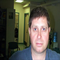

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:04<00:00, 2152.77it/s]



Top 10 closest images based on Color Moments:
1. Image ID: 188, Similarity Score: 6408.317412306694


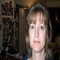

2. Image ID: 18, Similarity Score: 6543.087169941463


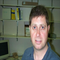

3. Image ID: 376, Similarity Score: 6777.657717765587


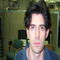

4. Image ID: 217, Similarity Score: 7078.733710944289


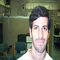

5. Image ID: 5, Similarity Score: 7319.146754165711


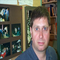

6. Image ID: 4, Similarity Score: 7454.315905227532


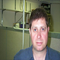

7. Image ID: 121, Similarity Score: 7517.111549062533


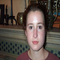

8. Image ID: 131, Similarity Score: 7663.610126761831


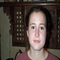

9. Image ID: 117, Similarity Score: 7724.7924049955955


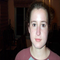

10. Image ID: 17, Similarity Score: 7780.695793122564


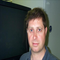


Top 10 closest images based on HOG:
1. Image ID: 4, Similarity Score: 9.310520762635962


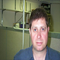

2. Image ID: 188, Similarity Score: 9.394265951007448


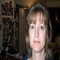

3. Image ID: 167, Similarity Score: 9.476429752513372


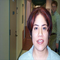

4. Image ID: 3963, Similarity Score: 9.554326444293379


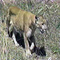

5. Image ID: 5, Similarity Score: 9.555852868026905


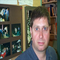

6. Image ID: 4709, Similarity Score: 9.675931978905211


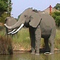

7. Image ID: 3351, Similarity Score: 9.677384154303788


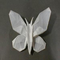

8. Image ID: 5176, Similarity Score: 9.694179927802509


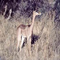

9. Image ID: 7744, Similarity Score: 9.71226240561794


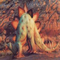

10. Image ID: 42, Similarity Score: 9.716599655451388


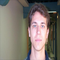


Top 10 closest images based on ResNet AvgPool Layer:
1. Image ID: 12, Similarity Score: 0.0


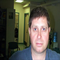

2. Image ID: 56, Similarity Score: 0.8770248989428975


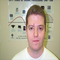

3. Image ID: 441, Similarity Score: 0.8924485133600344


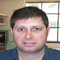

4. Image ID: 729, Similarity Score: 0.8951208813060517


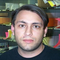

5. Image ID: 38, Similarity Score: 0.896928619522786


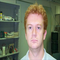

6. Image ID: 23, Similarity Score: 0.8978369827987018


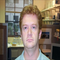

7. Image ID: 261, Similarity Score: 0.8985288319738827


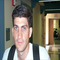

8. Image ID: 263, Similarity Score: 0.9003172731005311


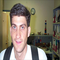

9. Image ID: 55, Similarity Score: 0.9015329754658561


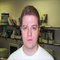

10. Image ID: 61, Similarity Score: 0.9025275295381169


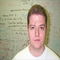

11. Image ID: 5, Similarity Score: 0.9027877404216704


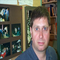


Top 10 closest images based on ResNet Layer3:
1. Image ID: 12, Similarity Score: 0.0


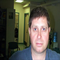

2. Image ID: 16, Similarity Score: 0.24189820885658264


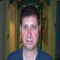

3. Image ID: 6, Similarity Score: 0.24369202554225922


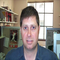

4. Image ID: 10, Similarity Score: 0.24369801580905914


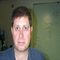

5. Image ID: 288, Similarity Score: 0.2437213808298111


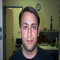

6. Image ID: 4, Similarity Score: 0.2437932789325714


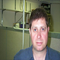

7. Image ID: 291, Similarity Score: 0.24728235602378845


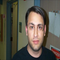

8. Image ID: 18, Similarity Score: 0.2480238974094391


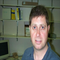

9. Image ID: 217, Similarity Score: 0.24971313774585724


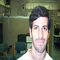

10. Image ID: 265, Similarity Score: 0.24972940981388092


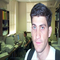

11. Image ID: 404, Similarity Score: 0.25103759765625


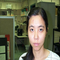


Top 10 closest images based on ResNet FC Layer:
1. Image ID: 12, Similarity Score: 0.0


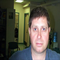

2. Image ID: 5, Similarity Score: 2.615401268005371


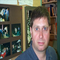

3. Image ID: 375, Similarity Score: 2.643994092941284


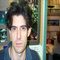

4. Image ID: 1, Similarity Score: 2.6447157859802246


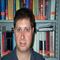

5. Image ID: 387, Similarity Score: 2.6544172763824463


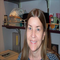

6. Image ID: 637, Similarity Score: 2.6594600677490234


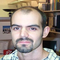

7. Image ID: 205, Similarity Score: 2.672194242477417


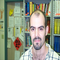

8. Image ID: 121, Similarity Score: 2.673332452774048


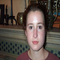

9. Image ID: 173, Similarity Score: 2.6803836822509766


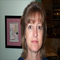

10. Image ID: 592, Similarity Score: 2.6823620796203613


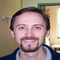

11. Image ID: 23, Similarity Score: 2.6831576824188232


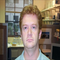

In [183]:
user_interface()

Enter the image ID to process (or 'q' to quit): 0
Input Image


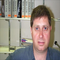

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:03<00:00, 2180.97it/s]



Top 10 closest images based on Color Moments:
1. Image ID: 155, Similarity Score: 6522.537489568226


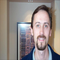

2. Image ID: 5160, Similarity Score: 6659.965562259577


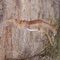

3. Image ID: 3196, Similarity Score: 6696.757134834082


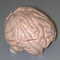

4. Image ID: 435, Similarity Score: 6780.418940786412


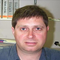

5. Image ID: 8188, Similarity Score: 6928.663152688041


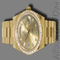

6. Image ID: 5058, Similarity Score: 6971.486155242581


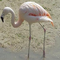

7. Image ID: 4978, Similarity Score: 6988.849696564484


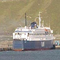

8. Image ID: 4255, Similarity Score: 7060.165349978116


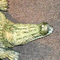

9. Image ID: 6181, Similarity Score: 7083.271436974557


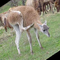

10. Image ID: 3165, Similarity Score: 7096.621125761538


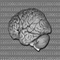


Top 10 closest images based on HOG:
1. Image ID: 6193, Similarity Score: 9.683682003864012


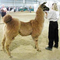

2. Image ID: 5836, Similarity Score: 9.715253745702775


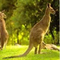

3. Image ID: 8226, Similarity Score: 9.838619552627847


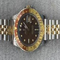

4. Image ID: 8370, Similarity Score: 9.876819414817554


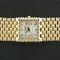

5. Image ID: 8187, Similarity Score: 9.88074801086846


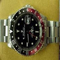

6. Image ID: 4311, Similarity Score: 9.88949200442366


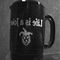

7. Image ID: 7389, Similarity Score: 9.899538737230237


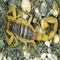

8. Image ID: 7118, Similarity Score: 9.910657233173929


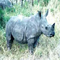

9. Image ID: 8319, Similarity Score: 9.916187209225273


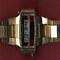

10. Image ID: 5680, Similarity Score: 9.927742421780504


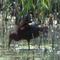


Top 10 closest images based on ResNet AvgPool Layer:
1. Image ID: 0, Similarity Score: 0.0


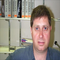

2. Image ID: 19, Similarity Score: 0.9031223857899182


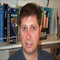

3. Image ID: 435, Similarity Score: 0.9034730091489749


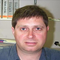

4. Image ID: 12, Similarity Score: 0.916597751519734


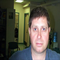

5. Image ID: 527, Similarity Score: 0.9214356797325258


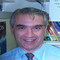

6. Image ID: 67, Similarity Score: 0.9216723174185791


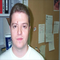

7. Image ID: 188, Similarity Score: 0.92312731066308


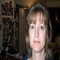

8. Image ID: 534, Similarity Score: 0.9281492846199279


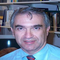

9. Image ID: 9, Similarity Score: 0.9288978795703127


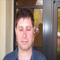

10. Image ID: 54, Similarity Score: 0.9313323193952542


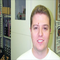

11. Image ID: 211, Similarity Score: 0.9330725082314458


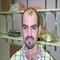


Top 10 closest images based on ResNet Layer3:
1. Image ID: 0, Similarity Score: 0.0


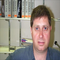

2. Image ID: 18, Similarity Score: 0.2286757230758667


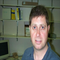

3. Image ID: 4, Similarity Score: 0.23285219073295593


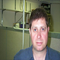

4. Image ID: 19, Similarity Score: 0.24194654822349548


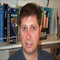

5. Image ID: 6, Similarity Score: 0.24818018078804016


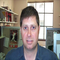

6. Image ID: 231, Similarity Score: 0.2501350939273834


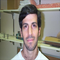

7. Image ID: 27, Similarity Score: 0.25211653113365173


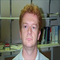

8. Image ID: 435, Similarity Score: 0.2521298825740814


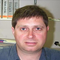

9. Image ID: 203, Similarity Score: 0.2521388530731201


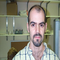

10. Image ID: 209, Similarity Score: 0.2542870342731476


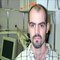

11. Image ID: 218, Similarity Score: 0.25702226161956787


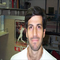


Top 10 closest images based on ResNet FC Layer:
1. Image ID: 0, Similarity Score: 0.0


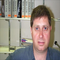

2. Image ID: 67, Similarity Score: 2.4015140533447266


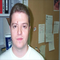

3. Image ID: 427, Similarity Score: 2.473554849624634


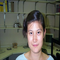

4. Image ID: 280, Similarity Score: 2.505309820175171


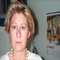

5. Image ID: 672, Similarity Score: 2.517016887664795


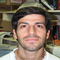

6. Image ID: 527, Similarity Score: 2.522615432739258


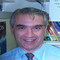

7. Image ID: 356, Similarity Score: 2.535269260406494


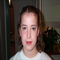

8. Image ID: 64, Similarity Score: 2.548548698425293


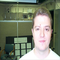

9. Image ID: 259, Similarity Score: 2.5499353408813477


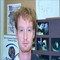

10. Image ID: 384, Similarity Score: 2.552790880203247


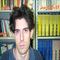

11. Image ID: 225, Similarity Score: 2.5528476238250732


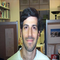

In [203]:
user_interface()    #for imageid 0

Enter the image ID to process (or 'q' to quit): 880
Input Image


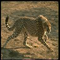

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:03<00:00, 2202.95it/s]


Top 10 closest images based on Color Moments:
1. Image ID: 980, Similarity Score: 3544.001791926121


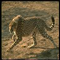

2. Image ID: 876, Similarity Score: 3717.5564679299137


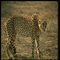

3. Image ID: 976, Similarity Score: 3877.684819325514


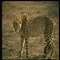

4. Image ID: 925, Similarity Score: 4028.565004002712


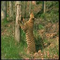

5. Image ID: 974, Similarity Score: 4100.215474442533


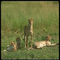

6. Image ID: 898, Similarity Score: 4146.952535014572


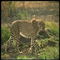

7. Image ID: 887, Similarity Score: 4152.6501358825835


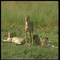

8. Image ID: 893, Similarity Score: 4159.830668547119


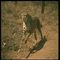

9. Image ID: 875, Similarity Score: 4164.743040610002


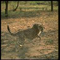

10. Image ID: 987, Similarity Score: 4201.8251563075355


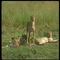


Top 10 closest images based on HOG:
1. Image ID: 978, Similarity Score: 6.407340949268747


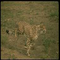

2. Image ID: 878, Similarity Score: 6.427020630445334


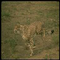

3. Image ID: 980, Similarity Score: 6.569641223488595


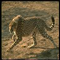

4. Image ID: 4481, Similarity Score: 6.644105769514354


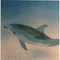

5. Image ID: 894, Similarity Score: 6.663939519504361


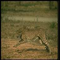

6. Image ID: 994, Similarity Score: 6.707610955756523


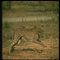

7. Image ID: 1017, Similarity Score: 6.787490323630604


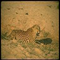

8. Image ID: 7406, Similarity Score: 6.799309511126169


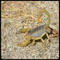

9. Image ID: 1061, Similarity Score: 6.823364315562069


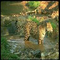

10. Image ID: 918, Similarity Score: 6.849101117107582


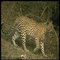


Top 10 closest images based on ResNet AvgPool Layer:
1. Image ID: 880, Similarity Score: 0.0


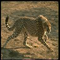

2. Image ID: 980, Similarity Score: 0.8644596520267186


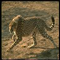

3. Image ID: 1065, Similarity Score: 0.901013142913426


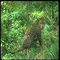

4. Image ID: 975, Similarity Score: 0.9077650417616933


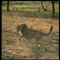

5. Image ID: 895, Similarity Score: 0.9092233701590644


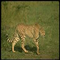

6. Image ID: 1010, Similarity Score: 0.9141746180679418


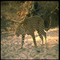

7. Image ID: 920, Similarity Score: 0.9162448446206748


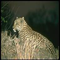

8. Image ID: 922, Similarity Score: 0.9175459205467591


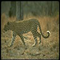

9. Image ID: 876, Similarity Score: 0.9207075761396581


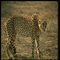

10. Image ID: 986, Similarity Score: 0.922564295852232


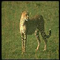

11. Image ID: 945, Similarity Score: 0.9239525190682144


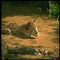


Top 10 closest images based on ResNet Layer3:
1. Image ID: 880, Similarity Score: 0.0


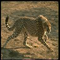

2. Image ID: 980, Similarity Score: 0.16968463361263275


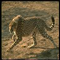

3. Image ID: 876, Similarity Score: 0.21511711180210114


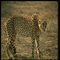

4. Image ID: 875, Similarity Score: 0.21962866187095642


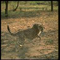

5. Image ID: 910, Similarity Score: 0.2226162701845169


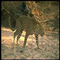

6. Image ID: 1010, Similarity Score: 0.22779713571071625


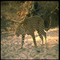

7. Image ID: 993, Similarity Score: 0.22843873500823975


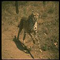

8. Image ID: 898, Similarity Score: 0.22904229164123535


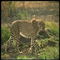

9. Image ID: 915, Similarity Score: 0.22992028295993805


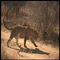

10. Image ID: 893, Similarity Score: 0.23116178810596466


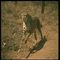

11. Image ID: 976, Similarity Score: 0.23234114050865173


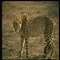


Top 10 closest images based on ResNet FC Layer:
1. Image ID: 880, Similarity Score: 0.0


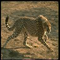

2. Image ID: 1002, Similarity Score: 2.5010106563568115


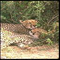

3. Image ID: 980, Similarity Score: 2.510432481765747


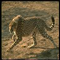

4. Image ID: 895, Similarity Score: 2.525635004043579


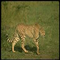

5. Image ID: 7433, Similarity Score: 2.5583887100219727


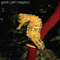

6. Image ID: 1010, Similarity Score: 2.5712668895721436


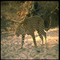

7. Image ID: 1022, Similarity Score: 2.581939935684204


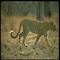

8. Image ID: 1034, Similarity Score: 2.607065439224243


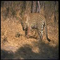

9. Image ID: 4280, Similarity Score: 2.614229917526245


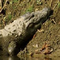

10. Image ID: 883, Similarity Score: 2.6219425201416016


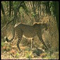

11. Image ID: 6733, Similarity Score: 2.6330277919769287


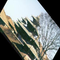

In [204]:
user_interface()     #for image id 880

Enter the image ID to process (or 'q' to quit): 2500
Input Image


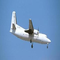

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:03<00:00, 2219.14it/s]



Top 10 closest images based on Color Moments:
1. Image ID: 2519, Similarity Score: 3728.237965743555


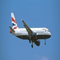

2. Image ID: 2301, Similarity Score: 3866.573439891708


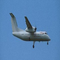

3. Image ID: 2524, Similarity Score: 3972.0047833714552


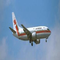

4. Image ID: 2308, Similarity Score: 4035.124477104883


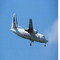

5. Image ID: 2504, Similarity Score: 4278.356107571425


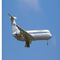

6. Image ID: 5007, Similarity Score: 4504.985154571466


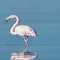

7. Image ID: 4503, Similarity Score: 4517.928851899362


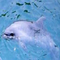

8. Image ID: 2567, Similarity Score: 4548.595344042515


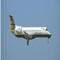

9. Image ID: 2245, Similarity Score: 4565.588720196393


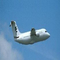

10. Image ID: 2410, Similarity Score: 4885.30889631232


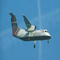


Top 10 closest images based on HOG:
1. Image ID: 2595, Similarity Score: 9.61897910022625


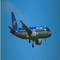

2. Image ID: 2562, Similarity Score: 9.643244480859371


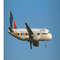

3. Image ID: 2217, Similarity Score: 9.69573296864362


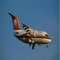

4. Image ID: 2635, Similarity Score: 9.732689577203919


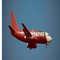

5. Image ID: 2413, Similarity Score: 9.752122497822512


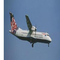

6. Image ID: 2632, Similarity Score: 9.755806570810808


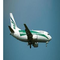

7. Image ID: 2798, Similarity Score: 9.810451242905613


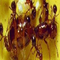

8. Image ID: 1433, Similarity Score: 9.838514821323253


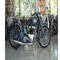

9. Image ID: 2368, Similarity Score: 9.861066710588444


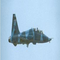

10. Image ID: 2612, Similarity Score: 9.898473146092341


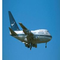


Top 10 closest images based on ResNet AvgPool Layer:
1. Image ID: 2500, Similarity Score: 0.0


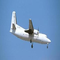

2. Image ID: 2308, Similarity Score: 0.8911157034749951


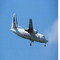

3. Image ID: 2670, Similarity Score: 0.8940949718041815


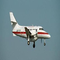

4. Image ID: 2635, Similarity Score: 0.8972391077707921


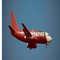

5. Image ID: 2196, Similarity Score: 0.916275861505775


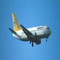

6. Image ID: 2552, Similarity Score: 0.9190438833528111


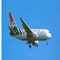

7. Image ID: 2609, Similarity Score: 0.919653620021574


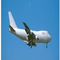

8. Image ID: 2567, Similarity Score: 0.9213411022974609


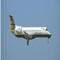

9. Image ID: 2549, Similarity Score: 0.9234993769217902


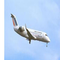

10. Image ID: 2570, Similarity Score: 0.9238680655487028


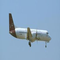

11. Image ID: 2517, Similarity Score: 0.9256485152797576


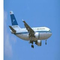


Top 10 closest images based on ResNet Layer3:
1. Image ID: 2500, Similarity Score: 0.0


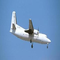

2. Image ID: 2308, Similarity Score: 0.2163442224264145


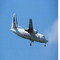

3. Image ID: 2569, Similarity Score: 0.22706130146980286


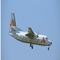

4. Image ID: 2486, Similarity Score: 0.2290526032447815


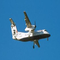

5. Image ID: 2519, Similarity Score: 0.22980092465877533


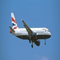

6. Image ID: 2492, Similarity Score: 0.2305711954832077


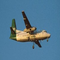

7. Image ID: 2624, Similarity Score: 0.23377685248851776


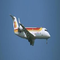

8. Image ID: 2570, Similarity Score: 0.23524565994739532


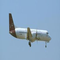

9. Image ID: 2253, Similarity Score: 0.23606717586517334


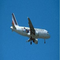

10. Image ID: 2214, Similarity Score: 0.23664404451847076


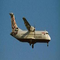

11. Image ID: 2304, Similarity Score: 0.23889152705669403


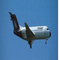


Top 10 closest images based on ResNet FC Layer:
1. Image ID: 2500, Similarity Score: 0.0


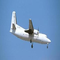

2. Image ID: 2670, Similarity Score: 2.5234060287475586


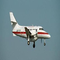

3. Image ID: 2490, Similarity Score: 2.5702311992645264


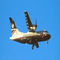

4. Image ID: 2196, Similarity Score: 2.6266086101531982


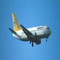

5. Image ID: 2218, Similarity Score: 2.627328634262085


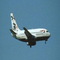

6. Image ID: 2308, Similarity Score: 2.6616828441619873


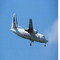

7. Image ID: 2519, Similarity Score: 2.6831231117248535


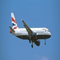

8. Image ID: 2206, Similarity Score: 2.6969797611236572


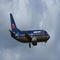

9. Image ID: 2270, Similarity Score: 2.69808292388916


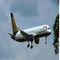

10. Image ID: 2484, Similarity Score: 2.708141803741455


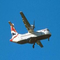

11. Image ID: 2252, Similarity Score: 2.7108523845672607


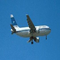

In [205]:
user_interface()     #for image id 2500

Enter the image ID to process (or 'q' to quit): 8676
Input Image


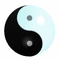

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [00:04<00:00, 2109.16it/s]


Top 10 closest images based on Color Moments:
1. Image ID: 8623, Similarity Score: 8275.526283396532


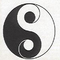

2. Image ID: 8639, Similarity Score: 9347.292299648485


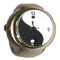

3. Image ID: 5434, Similarity Score: 9538.151913109557


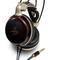

4. Image ID: 6939, Similarity Score: 10326.494953569867


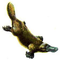

5. Image ID: 8653, Similarity Score: 10657.039361161653


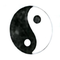

6. Image ID: 8657, Similarity Score: 10657.551954119395


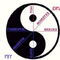

7. Image ID: 1457, Similarity Score: 10682.054792431269


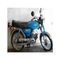

8. Image ID: 1361, Similarity Score: 10825.055502714167


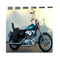

9. Image ID: 4703, Similarity Score: 10883.606691117293


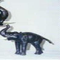

10. Image ID: 8617, Similarity Score: 10897.352913233079


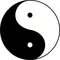


Top 10 closest images based on HOG:
1. Image ID: 6883, Similarity Score: 9.492565395236385


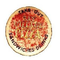

2. Image ID: 5474, Similarity Score: 9.6021562027486


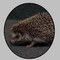

3. Image ID: 5166, Similarity Score: 9.67540199448619


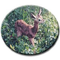

4. Image ID: 8034, Similarity Score: 9.840777140894591


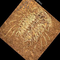

5. Image ID: 6893, Similarity Score: 9.869733937903566


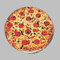

6. Image ID: 4643, Similarity Score: 10.001864430743016


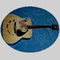

7. Image ID: 8211, Similarity Score: 10.152342246388113


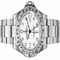

8. Image ID: 8033, Similarity Score: 10.182262205743216


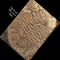

9. Image ID: 7829, Similarity Score: 10.186014266530606


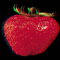

10. Image ID: 8301, Similarity Score: 10.406125071625931


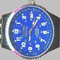


Top 10 closest images based on ResNet AvgPool Layer:
1. Image ID: 8676, Similarity Score: 0.0


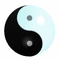

2. Image ID: 8670, Similarity Score: 0.9440856220508538


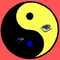

3. Image ID: 8619, Similarity Score: 0.9669267966859509


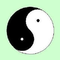

4. Image ID: 8650, Similarity Score: 0.9684877174313037


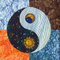

5. Image ID: 6871, Similarity Score: 0.9689850385212743


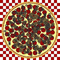

6. Image ID: 8659, Similarity Score: 0.9704429446043613


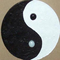

7. Image ID: 8631, Similarity Score: 0.9710814242473567


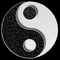

8. Image ID: 8663, Similarity Score: 0.9714083355833041


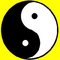

9. Image ID: 1506, Similarity Score: 0.9738195121225899


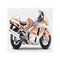

10. Image ID: 8632, Similarity Score: 0.9769593226725014


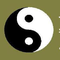

11. Image ID: 8660, Similarity Score: 0.9769739156803314


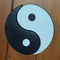


Top 10 closest images based on ResNet Layer3:
1. Image ID: 8676, Similarity Score: 0.0


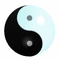

2. Image ID: 8619, Similarity Score: 0.31216418743133545


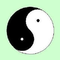

3. Image ID: 8640, Similarity Score: 0.31347569823265076


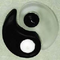

4. Image ID: 8632, Similarity Score: 0.31745368242263794


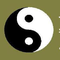

5. Image ID: 8670, Similarity Score: 0.3186982274055481


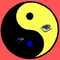

6. Image ID: 8653, Similarity Score: 0.324884295463562


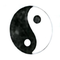

7. Image ID: 8623, Similarity Score: 0.32876721024513245


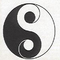

8. Image ID: 8660, Similarity Score: 0.33242562413215637


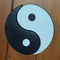

9. Image ID: 7533, Similarity Score: 0.33262330293655396


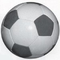

10. Image ID: 8639, Similarity Score: 0.3334293067455292


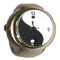

11. Image ID: 8650, Similarity Score: 0.3351595103740692


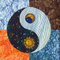


Top 10 closest images based on ResNet FC Layer:
1. Image ID: 8676, Similarity Score: 0.0


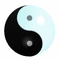

2. Image ID: 8653, Similarity Score: 2.671597719192505


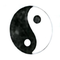

3. Image ID: 8663, Similarity Score: 2.766068458557129


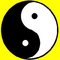

4. Image ID: 8619, Similarity Score: 2.832493543624878


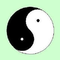

5. Image ID: 3371, Similarity Score: 2.8330471515655518


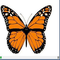

6. Image ID: 8631, Similarity Score: 2.862236499786377


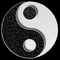

7. Image ID: 5439, Similarity Score: 2.865906000137329


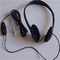

8. Image ID: 8640, Similarity Score: 2.882863998413086


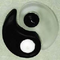

9. Image ID: 6808, Similarity Score: 2.9041996002197266


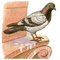

10. Image ID: 8116, Similarity Score: 2.9093239307403564


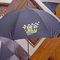

11. Image ID: 4805, Similarity Score: 2.9135046005249023


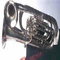

In [206]:
user_interface()     #for image id 8676

In [207]:
import pandas as pd

# Convert the hog_features_dict to a DataFrame
hog_features_df = pd.DataFrame.from_dict(hog_features_dict, orient='index')

# Rename the columns
hog_features_df.columns = [f'Feature_{i}' for i in range(hog_features_df.shape[1])]

# Add an ImageID column
hog_features_df['ImageID'] = hog_features_df.index

# Rearrange the columns to have ImageID as the first column
cols = ['ImageID'] + [col for col in hog_features_df.columns if col != 'ImageID']
hog_features_df = hog_features_df[cols]

# Save the DataFrame to a CSV file
hog_features_df.to_csv('hog_features_with_image_ids.csv', index=False)
